# Process

In [5]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(rc={"figure.figsize": (26, 10)})

In [2]:
sys.path.append("../")
from cnrdlib import cl_ml as clml

In [35]:
engine = create_engine(f"sqlite:///../data/RawData.db")
df_all = pd.read_sql_table("SensorData_5min", con=engine, index_col="timestamp")
df_all.head()

,WIP_temp,DP_temp,Ext_temp,WIP_current,DP_current
timestamp,,,,,
2021-03-30 00:00:00,4.828750,3.028125,17.063750,5.881250,9.741250
2021-03-30 00:05:00,4.299444,3.080000,17.474444,6.122778,9.839444
2021-03-30 00:10:00,4.506471,2.900588,17.605882,5.895000,9.783750
2021-03-30 00:15:00,4.075000,3.020000,17.395000,5.597059,9.704118
2021-03-30 00:20:00,4.044118,3.010000,17.536471,5.254118,8.987647


In [40]:
df_all.columns

Index(['WIP_temp', 'DP_temp', 'Ext_temp', 'WIP_current', 'DP_current'], dtype='object')

In [42]:
df = df_all.drop(['DP_temp', 'Ext_temp', 'WIP_current', 'DP_current'], axis=1)
df.head()

,WIP_temp
timestamp,
2021-03-30 00:00:00,4.828750
2021-03-30 00:05:00,4.299444
2021-03-30 00:10:00,4.506471
2021-03-30 00:15:00,4.075000
2021-03-30 00:20:00,4.044118


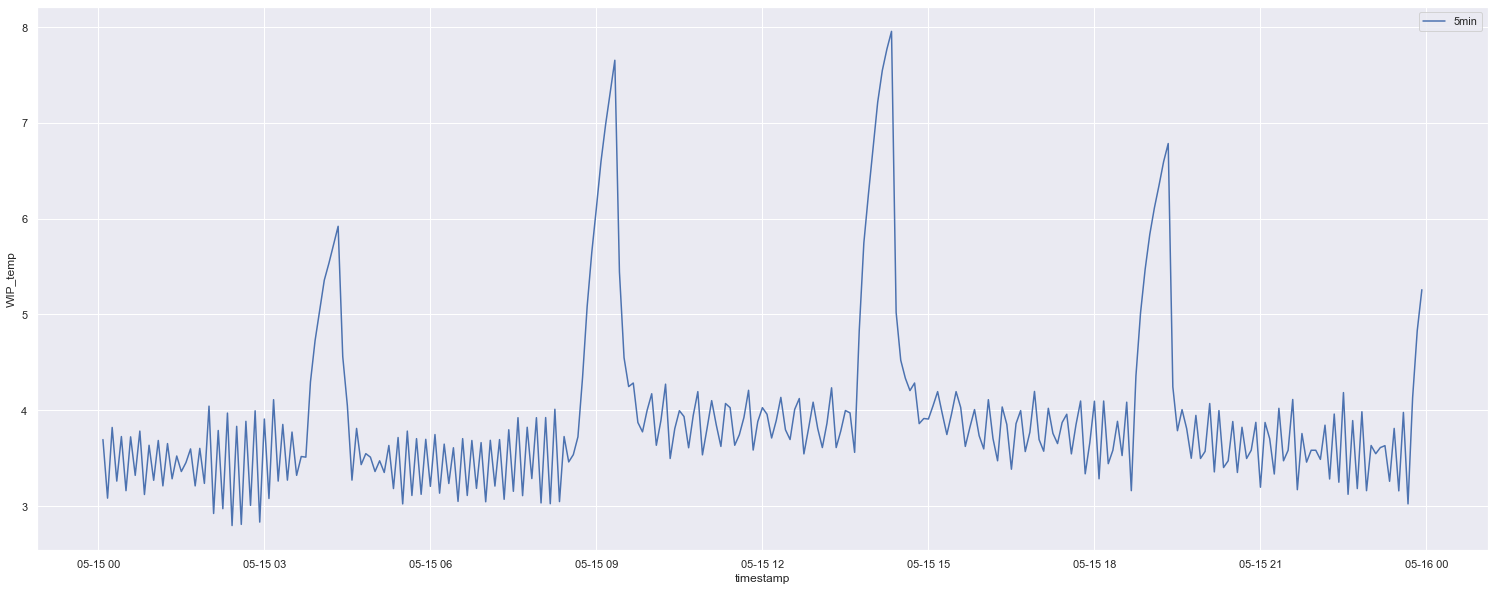

In [44]:
filter_5min = (df.index > '2021-05-15') & (df.index < '2021-05-16')
sns.lineplot(x=df.index[filter_5min], y="WIP_temp", data=df[filter_5min], label="5min");

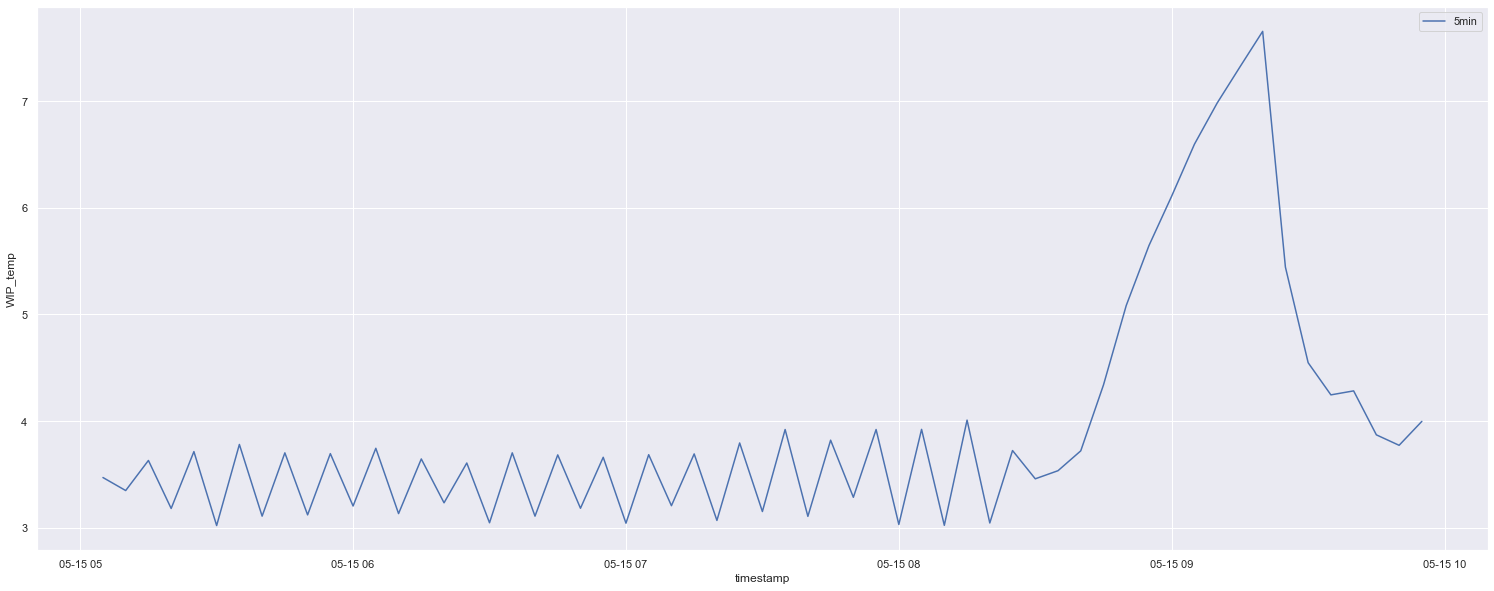

In [45]:
filter_cycle = (df.index > '2021-05-15 05:00') & (df.index < '2021-05-15 10:00')
sns.lineplot(x=df.index[filter_cycle], y="WIP_temp", data=df[filter_cycle], label="5min");

In [46]:
len(df[filter_cycle])

59

In [47]:
# Normalize and save the mean and std we get,
# for normalizing test data.
df_train = df[filter_5min]
training_mean = df_train.mean()
training_std = df_train.std()
df_training_value = (df_train - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 287


In [48]:
TIME_STEPS = 60

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (228, 60, 1)


In [49]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 30, 32)            256       
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 32)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 15, 16)            3600      
_________________________________________________________________
conv1d_transpose_6 (Conv1DTr (None, 30, 16)            1808      
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 16)            0         
_________________________________________________________________
conv1d_transpose_7 (Conv1DTr (None, 60, 32)            3616      
_________________________________________________________________
conv1d_transpose_8 (Conv1DTr (None, 60, 1)            

In [50]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
2/2 [==============================] - 1s 128ms/step - loss: 1.0868 - val_loss: 0.8109
Epoch 2/50
2/2 [==============================] - 0s 27ms/step - loss: 1.0109 - val_loss: 0.7508
Epoch 3/50
2/2 [==============================] - 0s 26ms/step - loss: 0.9145 - val_loss: 0.6739
Epoch 4/50
2/2 [==============================] - 0s 25ms/step - loss: 0.7938 - val_loss: 0.5860
Epoch 5/50
2/2 [==============================] - 0s 25ms/step - loss: 0.6647 - val_loss: 0.5042
Epoch 6/50
2/2 [==============================] - 0s 29ms/step - loss: 0.5606 - val_loss: 0.4552
Epoch 7/50
2/2 [==============================] - 0s 26ms/step - loss: 0.5293 - val_loss: 0.4279
Epoch 8/50
2/2 [==============================] - 0s 25ms/step - loss: 0.5125 - val_loss: 0.3803
Epoch 9/50
2/2 [==============================] - 0s 23ms/step - loss: 0.4463 - val_loss: 0.3333
Epoch 10/50
2/2 [==============================] - 0s 25ms/step - loss: 0.3905 - val_loss: 0.3075
Epoch 11/50
2/2 [===========

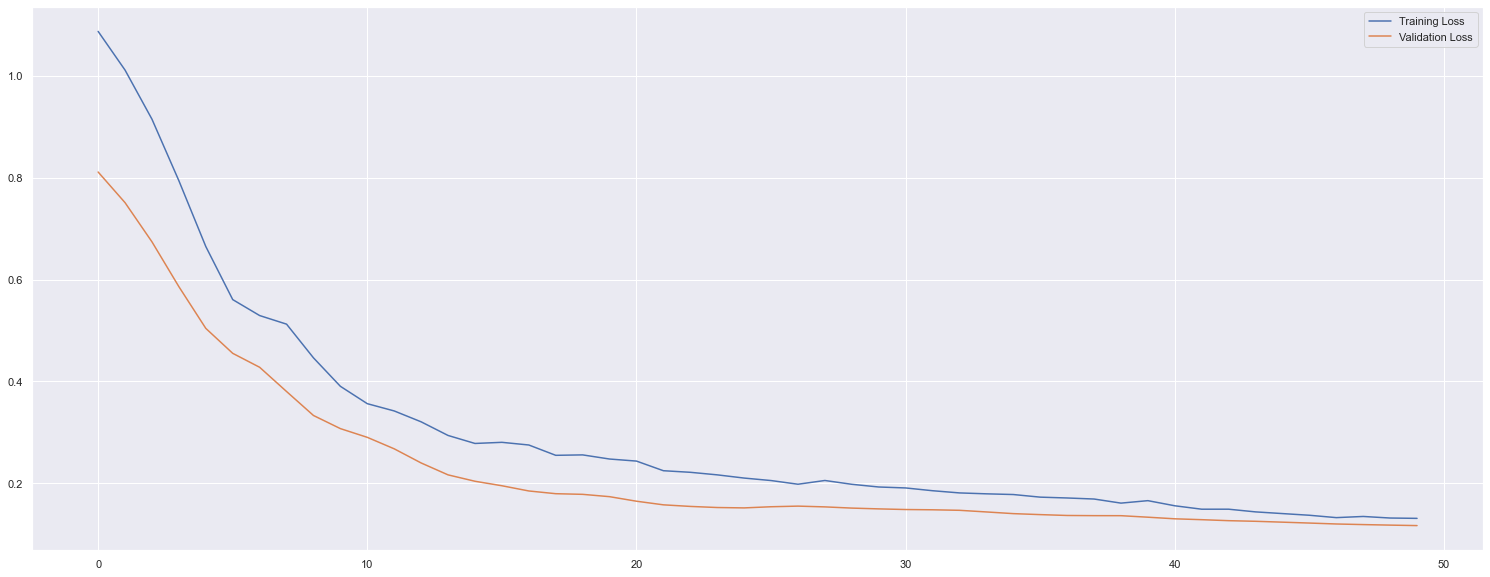

In [51]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

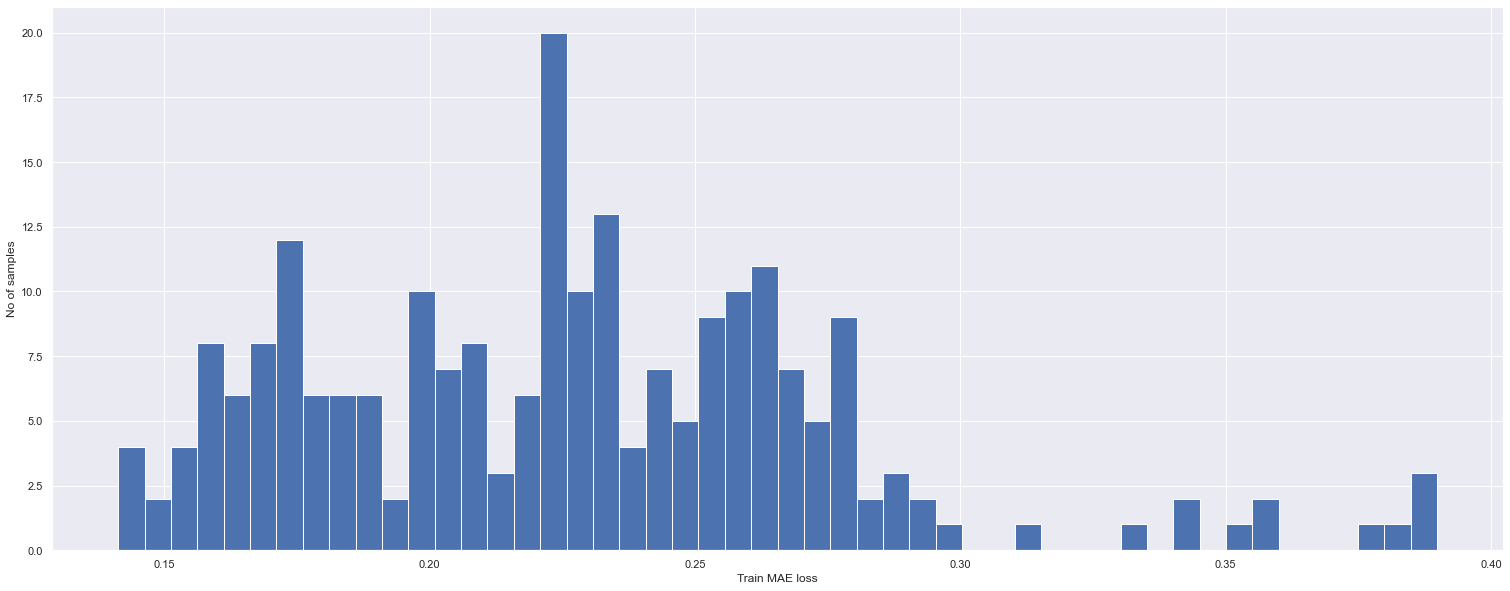

Reconstruction error threshold:  0.38982900963315215


In [52]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

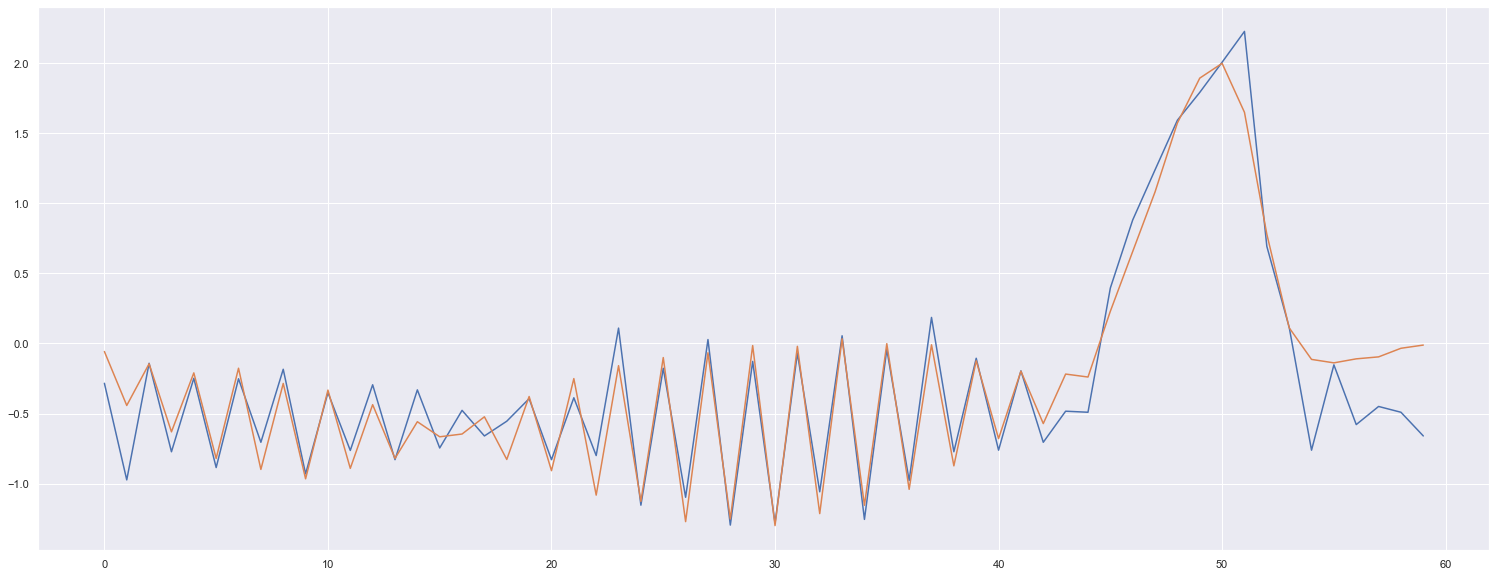

In [53]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

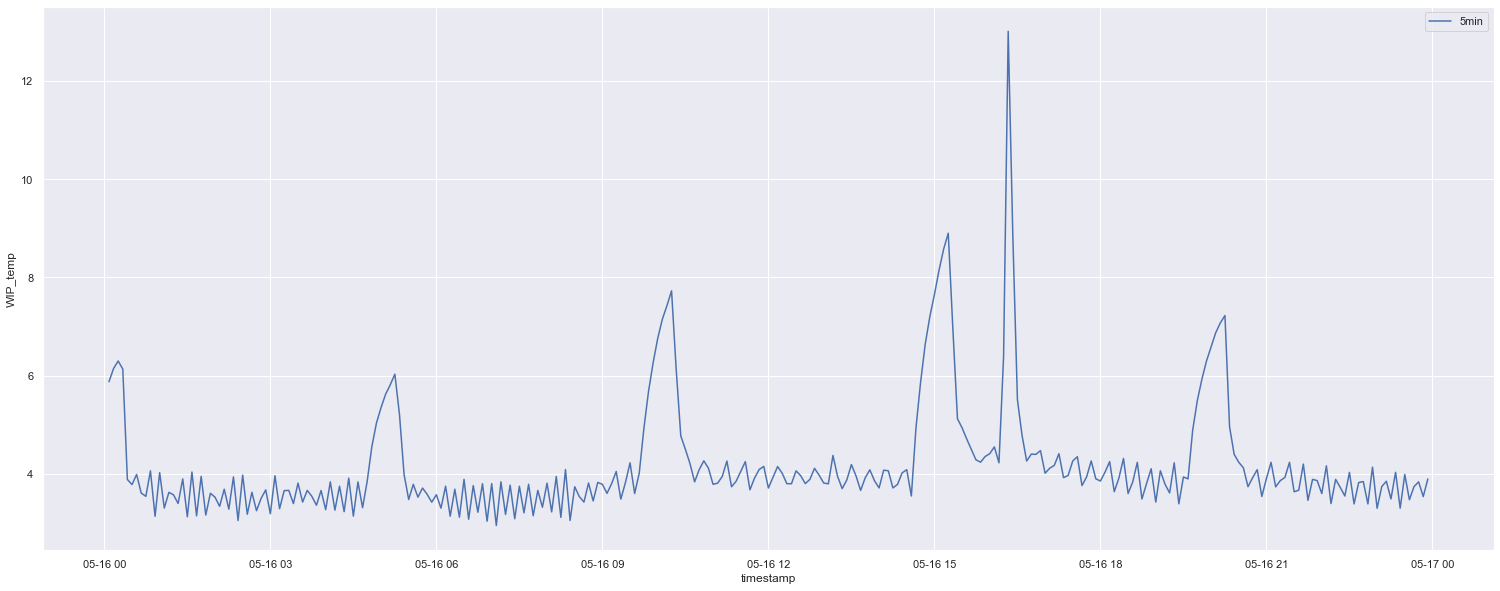

In [76]:
filter_anomaly = (df.index > '2021-05-16') & (df.index < '2021-05-17')
sns.lineplot(x=df.index[filter_anomaly], y="WIP_temp", data=df[filter_anomaly], label="5min");

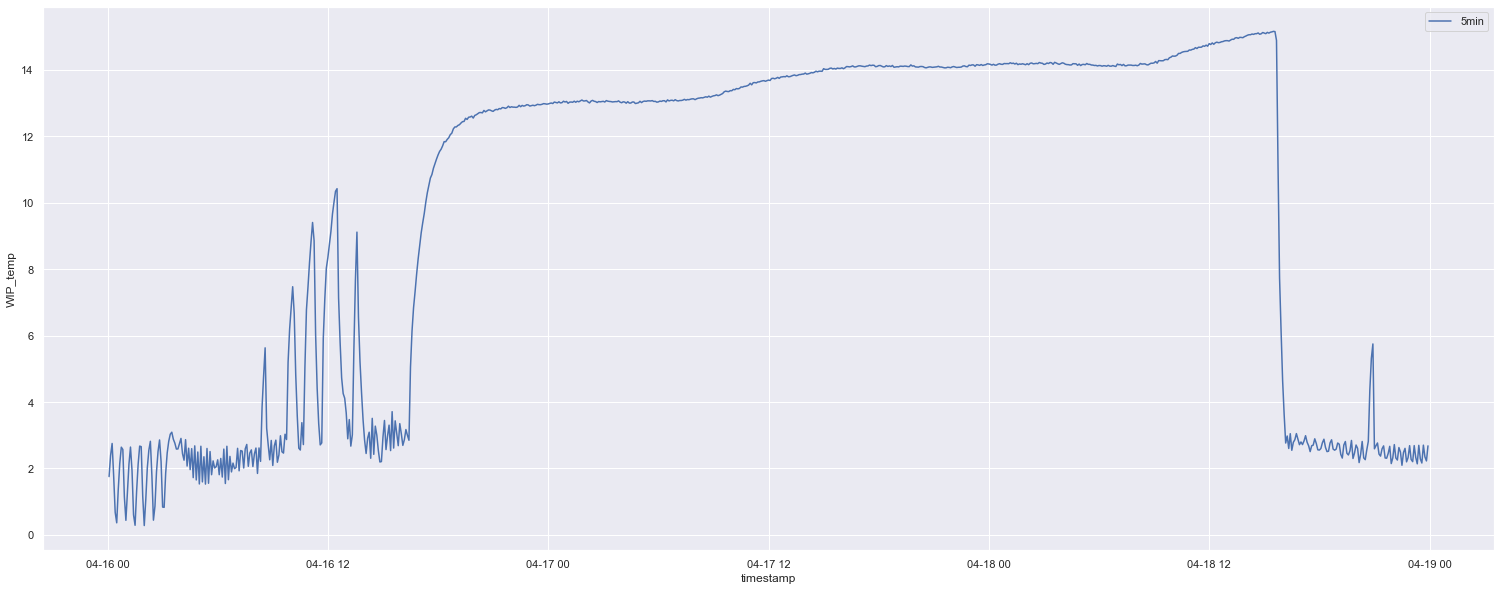

In [95]:
filter_anomaly = (df.index > '2021-04-16') & (df.index < '2021-04-19')
sns.lineplot(x=df.index[filter_anomaly], y="WIP_temp", data=df[filter_anomaly], label="5min");

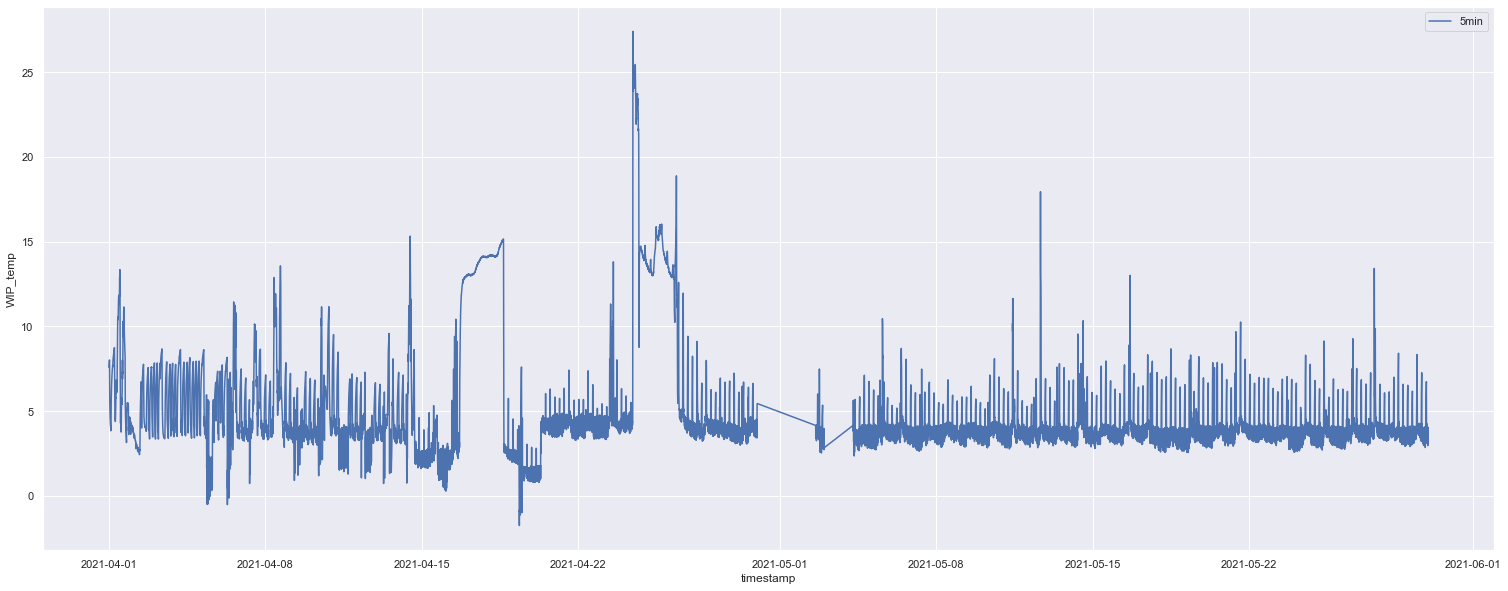

In [109]:
filter_anomaly = (df.index > '2021-04-01') & (df.index < '2021-05-30')
sns.lineplot(x=df.index[filter_anomaly], y="WIP_temp", data=df[filter_anomaly], label="5min");

In [110]:
df_anomaly = df[filter_anomaly]
df_anomaly.head()

,WIP_temp
timestamp,
2021-04-01 00:05:00,7.584706
2021-04-01 00:10:00,7.633333
2021-04-01 00:15:00,7.720000
2021-04-01 00:20:00,7.788235
2021-04-01 00:25:00,7.853333


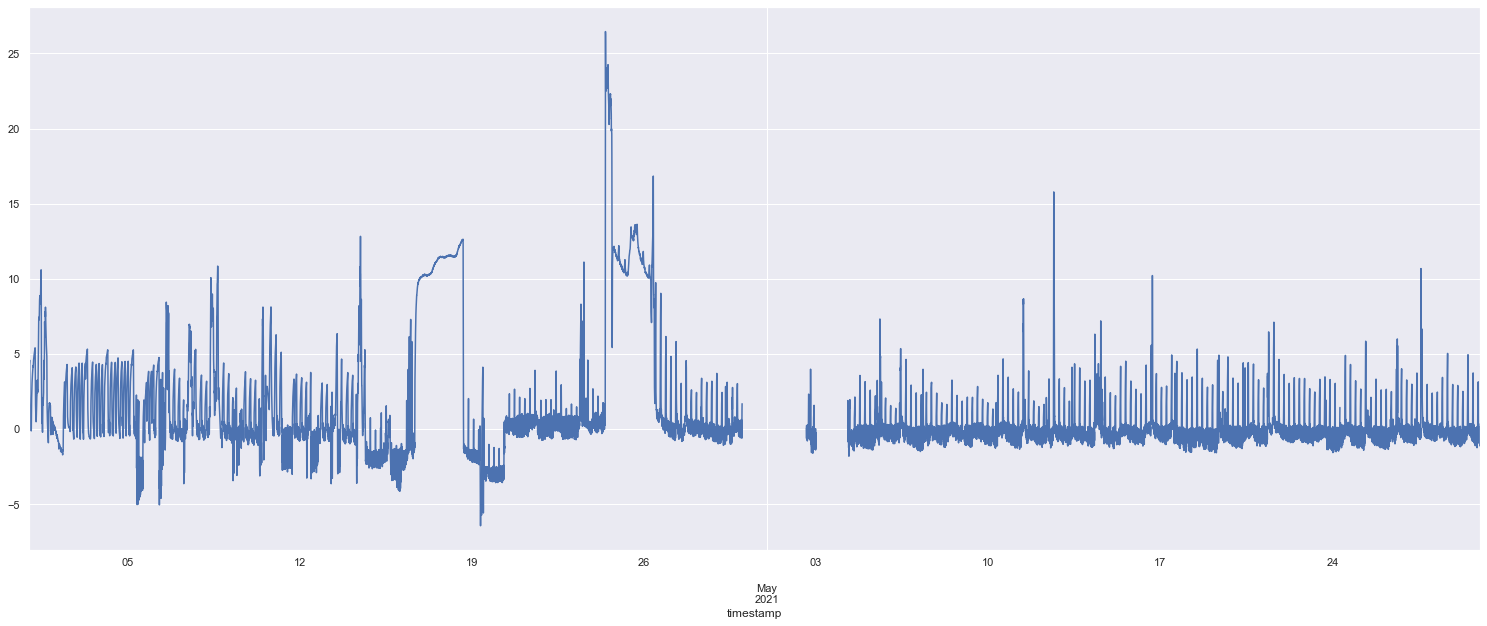

Test input shape:  (16932, 60, 1)


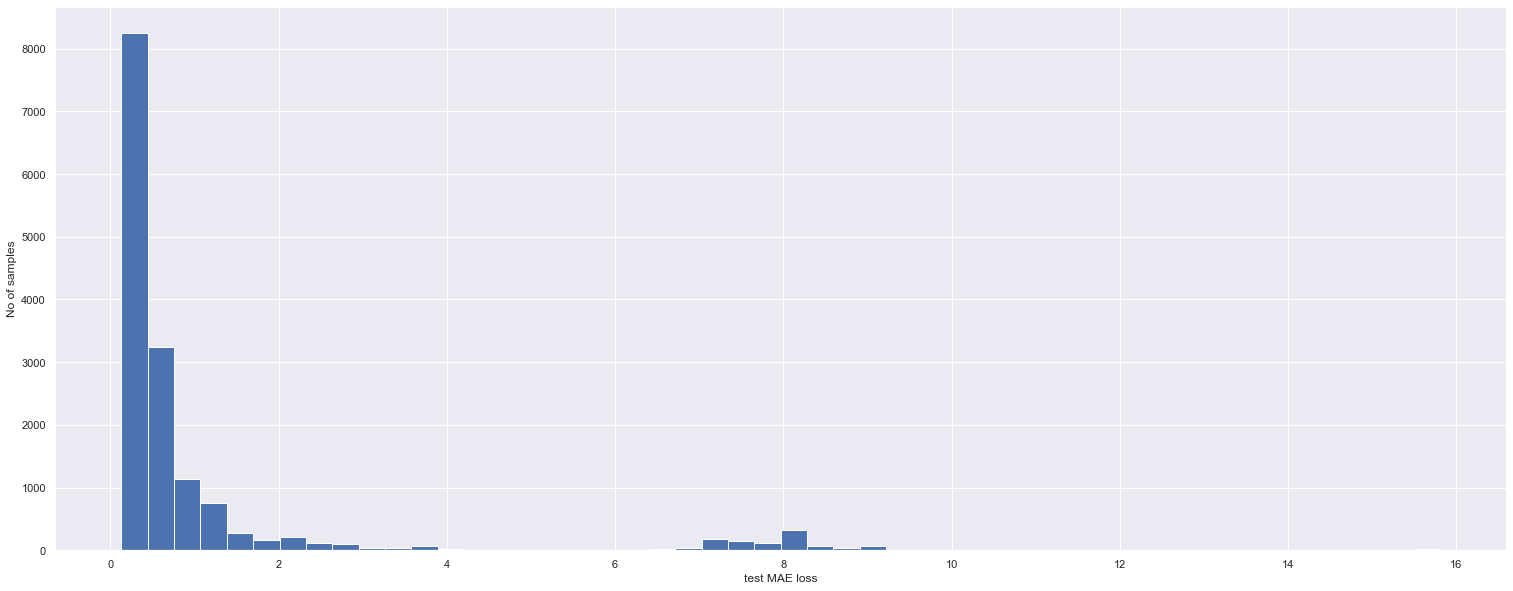

Number of anomaly samples:  8354


In [111]:
df_test_value = (df_anomaly - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
# print("Indices of anomaly samples: ", np.where(anomalies))

In [112]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

In [113]:
df_subset = df_anomaly.iloc[anomalous_data_indices]
df_subset.shape

(6208, 1)

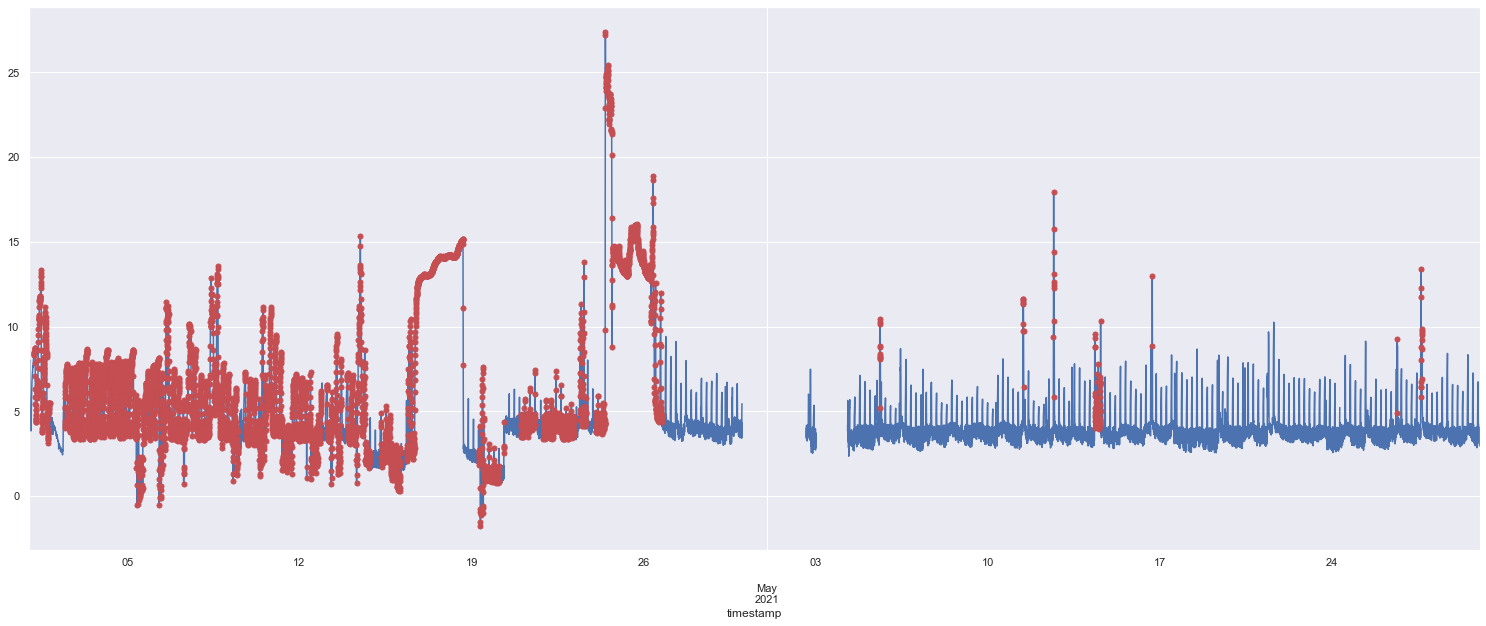

In [115]:
fig, ax = plt.subplots()
df_anomaly.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r", marker="o", markersize=5, linewidth=0)
plt.show()